## Project Question

## How well can we predict 'makes' or 'misses' in the NBA without looking at who is actually shooting the ball?

- How much do external factors matter when it comes to shooting?


- External factors are everything outside of the 1 primary factor, the person shooting the ball


- To me this seems like it would be the #1 factor in determining whether a shot is going to go in the basket or not.  For example, if you had to predict the # of 3 point makes out of 10 for both Shaq and Steph Curry.  Most people, even those who don't follow basketball, would know enough to have wildly different predictions for each guy.


- This information could help with coaching of all players, whether they are a great shooter, average shooter, or historically poor shooter.  For example a coach could learn tell his players: "No matter who you are here are 3 tips to getting better shooting results":


    - avoid taking shots when someone is guarding you closely
    - the closer you are to the basket, the better chance the ball will go in
    - don't wait until the shot or game clock is almost at 0 to shoot the ball

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
df = pd.read_csv('shot_logs.csv')
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


- Everything looks to have loaded in correctly

## Preprocessing/Exploration

- Any null values?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
GAME_ID                       128069 non-null int64
MATCHUP                       128069 non-null object
LOCATION                      128069 non-null object
W                             128069 non-null object
FINAL_MARGIN                  128069 non-null int64
SHOT_NUMBER                   128069 non-null int64
PERIOD                        128069 non-null int64
GAME_CLOCK                    128069 non-null object
SHOT_CLOCK                    122502 non-null float64
DRIBBLES                      128069 non-null int64
TOUCH_TIME                    128069 non-null float64
SHOT_DIST                     128069 non-null float64
PTS_TYPE                      128069 non-null int64
SHOT_RESULT                   128069 non-null object
CLOSEST_DEFENDER              128069 non-null object
CLOSEST_DEFENDER_PLAYER_ID    128069 non-null int64
CLOSE_DEF_DIST                128069 non-null

- Yes, SHOT_CLOCK has a few thousand null values


- Because we have over 125,000 data points I will just drop these rows with the null values


- SHOT_CLOCK turned out to be one of the most predictive features so I didn't want to have to input inaccurate values for the sake of full data

In [4]:
df = df.dropna()
df.reset_index(drop=True, inplace=True) 

- Am I going to use every feature from this dataset to make my model?


- We only need features that we think have to do with each shot going in or not

In [5]:
feature_columns = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', "GAME_CLOCK", "SHOT_CLOCK",
           'DRIBBLES', 'TOUCH_TIME', "SHOT_DIST", 'PTS_TYPE', 'CLOSE_DEF_DIST']

- These are the features I've chosen to keep, a few did not make the cut


- Now let's make a separate dataframe for just our features

In [6]:
features = df[feature_columns]

- Now we will do the same for our target


- Our target variable is a binary variable labeling whether each shot was made or missed

In [7]:
target_column = ['FGM']
target = (df[target_column]).squeeze()

- Are the datatypes of each variable correct?

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122502 entries, 0 to 122501
Data columns (total 10 columns):
LOCATION          122502 non-null object
SHOT_NUMBER       122502 non-null int64
PERIOD            122502 non-null int64
GAME_CLOCK        122502 non-null object
SHOT_CLOCK        122502 non-null float64
DRIBBLES          122502 non-null int64
TOUCH_TIME        122502 non-null float64
SHOT_DIST         122502 non-null float64
PTS_TYPE          122502 non-null int64
CLOSE_DEF_DIST    122502 non-null float64
dtypes: float64(4), int64(4), object(2)
memory usage: 9.3+ MB


- GAME_CLOCK is a string while SHOT_CLOCK is a float


- I think if we change GAME_CLOCK to a float variable as well, it can be used for your model


- In order to do that, the colon needs to be replaced with a period within each value.  Then the entire column can then be cast to a float type

In [9]:
features.GAME_CLOCK = features.GAME_CLOCK.apply(lambda x: x.replace(':', '.'))
features.GAME_CLOCK = features.GAME_CLOCK.astype(float)

- PTS_TYPE and PERIOD are both of INT type but I think these will be of more value as Categorical columns


- So their datatypes should be changed from INT to String


- Before that though, I noticed something unexpected in the list of values for PERIOD

In [10]:
features.PERIOD.value_counts()

1    32383
3    31032
2    30148
4    27941
5      809
6      149
7       40
Name: PERIOD, dtype: int64

- Besides the expected 1-4 values (as basketball is played in 4 quarter time periods) there are values of 5,6 and 7


- I would like to keep the data to just the normal 4 quarters so I will combine all the 5,6,7 values with the 4 values because the 4th period is very similar in feel to any overtime period

In [11]:
features.loc[features.PERIOD>4, 'PERIOD'] = 4

- Now we can change PTS_TYPE and PERIOD to be String variables to fit their Categorical nature


- Location is a categorical variable as well but it is already in the correct format so no need to change it

In [12]:
features.PERIOD = features.PERIOD.apply(lambda x: str(x))
features.PTS_TYPE = features.PTS_TYPE.apply(lambda x: str(x))

- Now is the time to convert our categorical variables into dummy variables using Pandas getdummies()


- Inspect

In [13]:
features = pd.get_dummies(features)
features

,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,LOCATION_A,LOCATION_H,PERIOD_1,PERIOD_2,PERIOD_3,PERIOD_4,PTS_TYPE_2,PTS_TYPE_3
0,1,1.09,10.8,2,1.9,7.7,1.3,1,0,1,0,0,0,1,0
1,2,0.14,3.4,0,0.8,28.2,6.1,1,0,1,0,0,0,0,1
2,4,11.47,10.3,2,1.9,17.2,3.4,1,0,0,1,0,0,1,0
3,5,10.34,10.9,2,2.7,3.7,1.1,1,0,0,1,0,0,1,0
4,6,8.15,9.1,2,4.4,18.4,2.6,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122497,4,5.05,15.3,2,1.6,8.9,5.7,1,0,0,1,0,0,1,0
122498,5,1.52,18.3,5,6.2,8.7,0.8,1,0,0,0,1,0,1,0
122499,6,11.28,19.8,4,5.2,0.6,0.6,1,0,0,0,0,1,1,0
122500,7,11.10,23.0,2,4.2,16.9,4.2,1,0,0,0,0,1,1,0


- A quick inspection of the transformed dataset shows no unexpected values were in the categorical columns.  Great


- Now that the categorical variables are ready for modeling, let's take a last look at the values in the continuous variables to make sure there are not outliers or unexpected data


- We will use a Box and Whisker plot of each continuous variable to show this

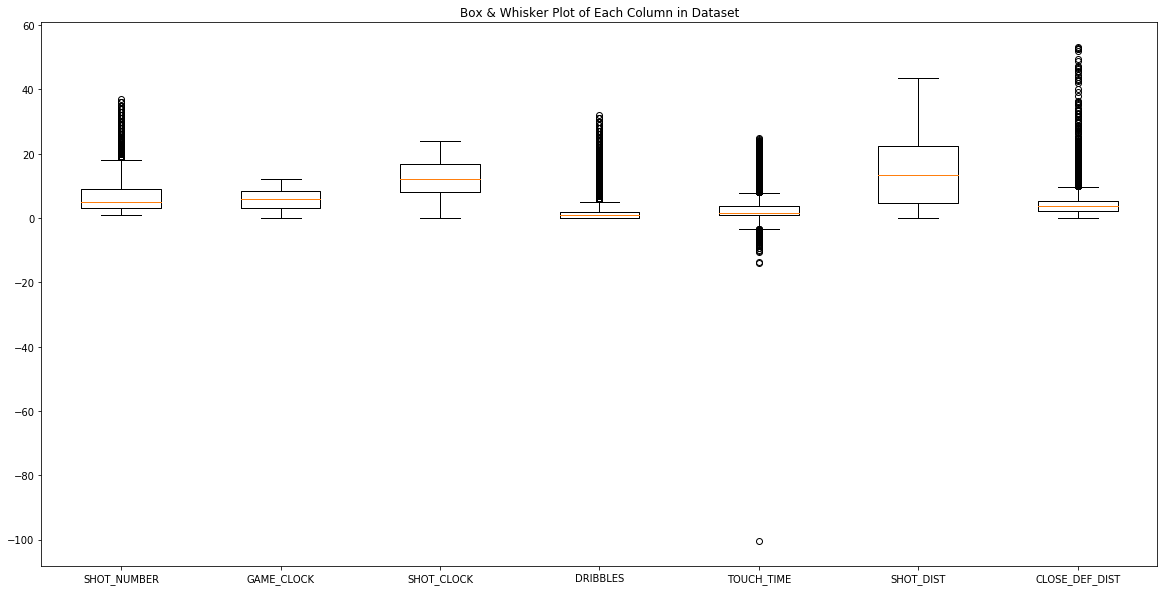

In [14]:
continuous = features[features.columns[:7]] #dataframe of just the continuous features

# Create a Box Whisker Plot of each column
plt.figure(figsize=(20, 10))
plt.boxplot([continuous[col] for col in continuous.columns])
plt.title("Box & Whisker Plot of Each Column in Dataset")
plt.xticks(range(1,len(continuous.columns.values)+1), continuous.columns.values)
plt.show()

- Everything looks within reason except there are some negative values for TOUCH_TIME.  That must be a mistake as it is impossible to touch the ball for a negative amount of time


- I think the best thing to do would just be to drop those faulty rows


- We need to make sure to drop these rows from both the features and target dataframes since that data is now separate

In [15]:
drops = features.loc[features.TOUCH_TIME<0, 'TOUCH_TIME'].index # get the index of the rows we will be dropping
features.drop(drops, inplace=True)
target.drop(drops, inplace=True)
# reset the index just to reorder things after removing some rows
features.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

- Let's explore the distribution of our target variable

In [16]:
target.value_counts(normalize=True)

0    0.543505
1    0.456495
Name: FGM, dtype: float64

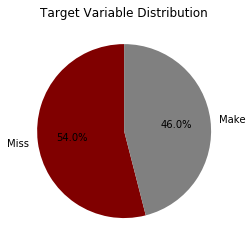

In [17]:
#Make A Pie Chart

plt.pie([54, 46], labels=['Miss', 'Make'], autopct='%1.1f%%', startangle=90, colors=['Maroon', 'Gray'],
       textprops={'color':'black'})
plt.title("Target Variable Distribution")
plt.show()

- Classification algorithms are most reliable when binary target variables have an even distribution


- Thankfully, ours isn't too far off.  About 46% of the data were makes and 54% were misses


- I am going to hope that is close enough to 50/50 for our model results to be useful

#### Multicollinearity?

In [18]:
continuous.corr()

,SHOT_NUMBER,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
SHOT_NUMBER,1.000000,-0.232661,-0.032683,0.144983,0.150743,0.005547,-0.037538
GAME_CLOCK,-0.232661,1.000000,0.020488,-0.104613,-0.097666,0.001592,0.008855
SHOT_CLOCK,-0.032683,0.020488,1.000000,-0.082771,-0.147688,-0.173026,0.026558
DRIBBLES,0.144983,-0.104613,-0.082771,1.000000,0.922755,-0.088753,-0.155250
TOUCH_TIME,0.150743,-0.097666,-0.147688,0.922755,1.000000,-0.089196,-0.167290
SHOT_DIST,0.005547,0.001592,-0.173026,-0.088753,-0.089196,1.000000,0.532083
CLOSE_DEF_DIST,-0.037538,0.008855,0.026558,-0.155250,-0.167290,0.532083,1.000000


- The only multicollinearity problem within our features is between TOUCH_TIME and DRIBBLES (with a .922 correlation!)


- I think it would be smart to keep only one of these two variables for modeling (this will be taken care of in the next section)

#### Train Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features,target, random_state=123)

### Scaling down the Dataset / Reducing # of Features

- Due to having well over 100,000 rows of data and 16 features, the modeling steps were taking too long.  I did not want to reduce the amount of rows in my dataset so I looked into reducing the number of features I would use


- I examined the feature importance of a couple models I knew I would be testing with to find out that 6 of the features accounted for most of the variability in the target labels


- So I decided to move forward with the modeling step using a dataframe of features with only the top 6


- This made the runtime of the fitting of each model more manageable to the point where I was able to test more models

In [20]:
# Here is a function to help with plotting the importance of each feature to a model's predictions

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

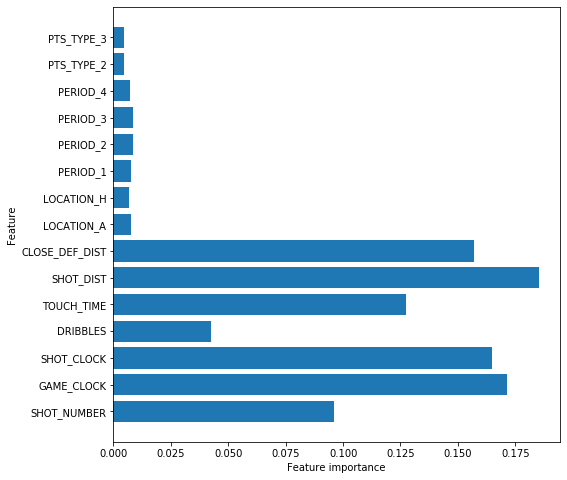

In [21]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
plot_feature_importances(random_forest)

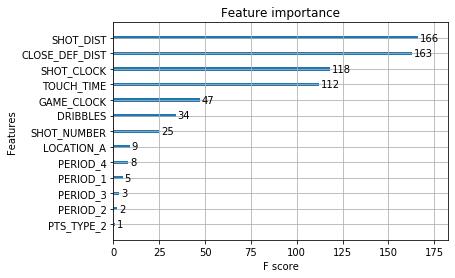

In [22]:
XGBoost = XGBClassifier()
XGBoost.fit(X_train, y_train)
plot_importance(XGBoost)

- The top 6 features are SHOT_DIST, CLOSE_DEF_DIST, TOUCH_TIME, SHOT_CLOCK, GAME_CLOCK, and SHOT_NUMBER


- Let's slice our Features dataframe to reflect this


- Now we are ready to make some models!

In [23]:
top6 = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'TOUCH_TIME', 'GAME_CLOCK', 'SHOT_NUMBER']
features = features[top6]

#### Surprises / Interesting Occurences

- All 6 of the most important features I ended keeping in the model were continuous variables.  So none of the categorical variables made the cut


- I thought that PTS_TYPE would have had more effect on the target variable.  Afterall, 2 point shots in general are easier to make than 3 point shots.  League averages of each type of shot year to year show this out


- I thought LOCATION might have had a bit more effect on the target variable as well.  Overall, teams at home play better than on the road


- I thought there might have been a multicollinearity problem between SHOT_CLOCK and GAME_CLOCK but there wasn't one

## Modeling

In [24]:
# Helper function to print to screen 4 of the most important metrics for classification performance

def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

- I will now make a list to store the accuracy of each model we fit to our data so that in the end we can easily show which performed the best

In [25]:
model_performance_list = []

### Logistic Regression

- Baseline Model

In [26]:
pipe_lr = Pipeline([('ss', StandardScaler()), 
                    ('clf', LogisticRegression())])

pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_test, y_test)

0.603646361821217

- Parameter tuning with GridSearchCV


- Parameter Options tested:


    - C: .001,.01,.1,1,10
    - fit_intercept: True, False
    - solver: liblinear, lbfgs
    

- Best Parameters:


    - C: .001
    - fit_intercept: True
    - solver: lbfgs

- Rerun the model, this time with the optimal paramters so we can get a look at more of the metrics for our model


- I am treating Accuracy as the most important metric for this simple problem but I would like to have other metrics to compare if multiple models are similarly good and need a tiebreaker

In [27]:
pipe_lr = Pipeline([('ss', StandardScaler()), 
                    ('clf', LogisticRegression(C=.001, fit_intercept=True, solver='lbfgs'))])

pipe_lr.fit(X_train, y_train)
y_preds1 = pipe_lr.predict(X_test)
print_metrics(y_test, y_preds1)

# add to performance list
model_performance_list.append(('Logit', accuracy_score(y_test, y_preds1)))

Precision Score: 0.5893436711143166
Recall Score: 0.4655982905982906
Accuracy Score: 0.6053157016136951
F1 Score: 0.5202132739137355


### K-Nearest Neighbors

- Baseline model

In [28]:
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('clf', KNeighborsClassifier())])

pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_test, y_test)

0.5577558836044647

- Parameter tuning with GridSearhCV


- Parameter Options tested:


    - n_neighbors: 5,25,50,100
    

- Best Parameters:


    - n_neighbors: 100

- Performance of Tuned Model

In [29]:
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=100))])

pipe_knn.fit(X_train, y_train)
y_preds2 = pipe_knn.predict(X_test)
print_metrics(y_test, y_preds2)

# add to performance list
model_performance_list.append(('KNN', accuracy_score(y_test, y_preds2)))

Precision Score: 0.6084612680182819
Recall Score: 0.3698005698005698
Accuracy Score: 0.6010277895977219
F1 Score: 0.46001860629956143


### Decision Tree

- Baseline

In [30]:
pipe_dt = Pipeline([
    ('ss', StandardScaler()),
    ('clf', DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)
pipe_dt.score(X_test, y_test)

0.5395240744983798

- Parameter tuning with GridSearchCV


- Parameter Options tested:


    - criterion: gini, entropy
    - max_depth: 1,2,3,5,10
    - min_samples_split: 2,5,10
    - min_samples_leaf: 1,5,10
    

- Best Parameters:


    - criterion: gini
    - max_depth: 5
    - min_samples_split: 2
    - min_samples_leaf: 1

- Performance of Tuned Model

In [31]:
pipe_dt = Pipeline([
    ('ss', StandardScaler()),
    ('clf', DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=1))])

pipe_dt.fit(X_train, y_train)
y_preds3 = pipe_dt.predict(X_test)
print_metrics(y_test, y_preds3)

# add to performance list
model_performance_list.append(('Decision Tree', accuracy_score(y_test, y_preds3)))

Precision Score: 0.6565340909090909
Recall Score: 0.3292022792022792
Accuracy Score: 0.6125822395338941
F1 Score: 0.4385199240986717


### Bagged Trees

- Baseline

In [32]:
pipe_bt = Pipeline([('ss', StandardScaler()), 
                    ('clf', BaggingClassifier())])
pipe_bt.fit(X_train, y_train)
pipe_bt.score(X_test, y_test)

0.5760204248633433

- The BaggingClassifier uses a DecisionTreeClassifier as it's default estimator


- So since we already tuned the paramters for a Decision Tree, I will just use those here


- Will be interesting to see how different the results are from the Decision Tree model we just ran

In [33]:
pipe_bt = Pipeline([('ss', StandardScaler()), 
                    ('clf', BaggingClassifier(DecisionTreeClassifier(criterion='gini',
                                                                         max_depth=5,
                                                                         min_samples_leaf=1,
                                                                         min_samples_split=2)))])
pipe_bt.fit(X_train, y_train)
y_preds4 = pipe_bt.predict(X_test)
print_metrics(y_test, y_preds4)

# add to performance list
model_performance_list.append(('Bagged Trees', accuracy_score(y_test, y_preds4)))

Precision Score: 0.6574190836485918
Recall Score: 0.33418803418803417
Accuracy Score: 0.6139897221040228
F1 Score: 0.44312225527695137


### Random Forest

- Baseline

In [34]:
pipe_rf = Pipeline([('ss', StandardScaler()), 
                    ('clf', RandomForestClassifier())])
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_test, y_test)

0.5758567640993748

- Parameter tuning with GridSearchCV


- Parameter Options tested:


    - criterion: gini, entropy
    - max_depth: 1,2,3,5,10
    - min_samples_split: 2,5,10
    - min_samples_leaf: 1,5,10
    

- Best Parameters:


    - criterion: entropy
    - max_depth: 10
    - min_samples_split: 2
    - min_samples_leaf: 5

- Performance of Tuned Model

In [35]:
pipe_rf = Pipeline([('ss', StandardScaler()), 
                    ('clf', RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=2,
                                                  min_samples_leaf=5))])

pipe_rf.fit(X_train, y_train)
y_preds5 = pipe_rf.predict(X_test)
print_metrics(y_test, y_preds5)

# add to performance list
model_performance_list.append(('Random Forest', accuracy_score(y_test, y_preds5)))

Precision Score: 0.6445846477392219
Recall Score: 0.3492877492877493
Accuracy Score: 0.6124513109227194
F1 Score: 0.4530672579453067


### Gradient Boost

- Baseline

In [36]:
pipe_gb = Pipeline([('ss', StandardScaler()), 
                    ('clf', GradientBoostingClassifier())])
pipe_gb.fit(X_train, y_train)
pipe_gb.score(X_test, y_test)

0.6156263297437072

- Parameter tuning with GridSearchCV


- Parameter Options tested:


    - learning_rate: .01,.1,1
    - n_estimators: 5,50,100
    - max_depth: 1,2,5
    

- Best Parameters:


    - learning_rate: .1
    - n_estimators: 100
    - max_depth: 2
    
    
- Performance of Tuned Model

In [37]:
pipe_gb = Pipeline([('ss', StandardScaler()), 
                    ('clf', GradientBoostingClassifier(learning_rate=.1, n_estimators=100, max_depth=2))])

pipe_gb.fit(X_train, y_train)
y_preds6 = pipe_gb.predict(X_test)
print_metrics(y_test, y_preds6)

# add to performance list
model_performance_list.append(('Gradient Boost', accuracy_score(y_test, y_preds6)))

Precision Score: 0.6501054296257248
Recall Score: 0.35135327635327634
Accuracy Score: 0.6150044188406272
F1 Score: 0.4561679304605141


### AdaBoost

- Baseline

In [38]:
pipe_ab = Pipeline([('ss', StandardScaler()), 
                    ('clf', AdaBoostClassifier())])
pipe_ab.fit(X_train, y_train)
pipe_ab.score(X_test, y_test)

0.6073450950869038

- Parameter tuning with GridSearchCV


- Parameter Options tested:


    - learning_rate: .01,.1,1
    - n_estimators: 5,50,100
    

- Best Parameters:


    - learning_rate: .1
    - n_estimators: 100
    
    
- Performance of Tuned Model

In [39]:
pipe_ab = Pipeline([('ss', StandardScaler()), 
                    ('clf', AdaBoostClassifier(learning_rate=.1, n_estimators=100))])

pipe_ab.fit(X_train, y_train)
y_preds7 = pipe_ab.predict(X_test)
print_metrics(y_test, y_preds7)

# add to performance list
model_performance_list.append(('AdaBoost', accuracy_score(y_test, y_preds7)))

Precision Score: 0.6216864716636198
Recall Score: 0.38753561253561253
Accuracy Score: 0.6101600602271612
F1 Score: 0.47744822744822746


### XGBoost

- Baseline

In [40]:
pipe_xgb = Pipeline([('ss', StandardScaler()), 
                    ('clf', XGBClassifier())])
pipe_xgb.fit(X_train, y_train)
pipe_xgb.score(X_test, y_test)

0.6155281332853262

- Parameter tuning with GridSearchCV


- Parameter Options tested:


    - learning_rate: .01,.1,1
    - n_estimators: 5,50,100
    - max_depth: 1,2,4
    

- Best Parameters:


    - learning_rate: .1
    - n_estimators: 50
    - max_depth: 4
    
    
- Performance of Tuned Model

In [41]:
pipe_xgb = Pipeline([('ss', StandardScaler()), 
                    ('clf', XGBClassifier(learning_rate=.1, n_estimators=50, max_depth=4))])

pipe_xgb.fit(X_train, y_train)
y_preds8 = pipe_xgb.predict(X_test)
print_metrics(y_test, y_preds8)

# add to performance list
model_performance_list.append(('XGBoost', accuracy_score(y_test, y_preds8)))

Precision Score: 0.6598094712135856
Recall Score: 0.3403846153846154
Accuracy Score: 0.6162155084939936
F1 Score: 0.4490908236620777


### Support Vector Machines

- Baseline

In [42]:
# takes a long time to run so I have added the score I got after successfully running the code once to the performance list
# manually

# pipe_svm = Pipeline([('ss', StandardScaler()), 
#                     ('clf', SVC())])
# pipe_svm.fit(X_train, y_train)
# pipe_svm.score(X_test, y_test)

In [43]:
# add to performance list
model_performance_list.append(('SVM', .6126))

- SVMs were the last algorithm I investigated for my data


- The runtime was long just for the baseline model so I was not able to execute a grid search to explore other parameters for this algorithm due to what would have been extremely long runtimes


- So the baseline SVM was what I used as my final model for this algorithm

## Model Comparison  / Which One Performed Best?

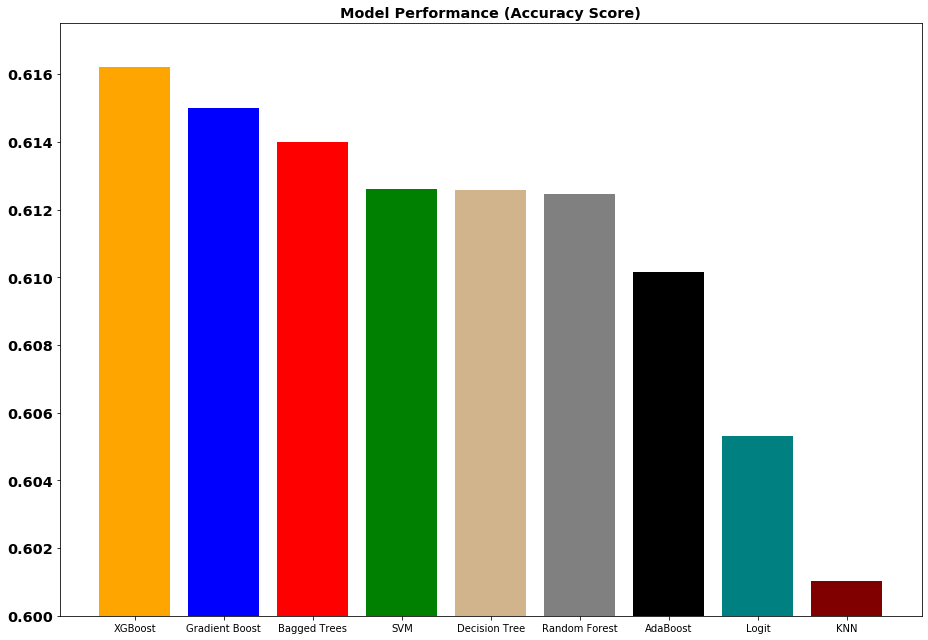

In [45]:
performances = sorted(model_performance_list, key=lambda x: x[1], reverse=True)
x,y = zip(*performances)

plt.figure(figsize=(13,9))
plt.bar(x, y, color=['Orange', 'Blue', 'Red', 'Green', 'Tan', 'Gray', 'Black', 'Teal', 'Maroon'])
plt.ylim([.6, .6175])
plt.yticks(color='black', size='x-large', weight='bold')
plt.xticks(color='black')
plt.title("Model Performance (Accuracy Score)", color='black', size='x-large', weight='bold')
plt.tight_layout()

## XGBoost wins!

- The ensemble method XGBoost had the best accuracy score of all the algorithms we tested


- There was not a lot of difference between the best performing algorithms, only a few hundredths of a percent


- K Nearest Neighbors was by far the worst performing model, Logistic Regression the 2nd worst

## What It All Means

- The breakdown of makes to misses in the NBA that year was approximately 46% to 54%, respectively.  So we know that even if we guessed that all shots were missed we would still predict 54% of the results correctly.  So when looking at the performance from the models we tested, we needed to see accuracy greater than 54% to know we were doing any better than random chance


- Our winning model (XGBoost) had an accuracy of 61.6%.  This doesn't seem like a great number.  Only about an 8% improvement on random guessing.  


- But you have to remember that we are predicting something that in itself is highly variable.  Outside of dunks and layups, wide-open shots for the very best shooters are still not even close to guaranteed to go in.  


- So having an accuracy of prediction this low even for our best performing model is not all that surprising

## Improvements

### Model

- With more time and/or computing power, we could try to tune more parameters for each model hoping to find small improvements  

- I would also have liked to explore further the different kernel options of Support Vector Machines 

### Data

- New data / features that I think could help give better predictions:


    - last year's defensive field goal pct. of closest defender
    - last year's field goal pct. of the type of shot taken (2 or 3) from that same player
    - what % of your total shots attemted (so far that season, or overall from last year) is the shot you are about to take?